In [1]:
import os
# os.environ["JAX_ENABLE_X64"] = "1"
import itertools
from functools import partial

import numpy as np
from tqdm import tqdm

import jax
jax.config.update("jax_default_matmul_precision", "highest")
import jax.numpy as jnp
from jax_tqdm import scan_tqdm

from gauge_field_utils import coef_to_lie_group, wilson_action, mean_wilson_rectangle, accurate_wilson_hamiltonian_error
from integrators import int_LF2, int_MN2_omelyan, int_MN4_takaishi_forcrand

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def HMC(beta, afn, nfev_approx):
    action_fn = lambda x: afn(coef_to_lie_group(x), beta)
    action_grad_fn = jax.grad(action_fn)
    
    def step_fn(coef, tau, random_key):
        key1, key2 = jax.random.split(random_key, num=2)
        p0 = jax.random.normal(key1, shape=coef.shape, dtype=coef.dtype)

        coef_prop, pt = int_MN4_takaishi_forcrand(coef, p0, action_grad_fn, tau, nfev_approx)
        dH = accurate_wilson_hamiltonian_error(coef, p0, coef_prop, pt, beta)

        p_acc = jnp.minimum(1, jnp.exp(-dH))

        coef_next = jax.lax.cond(
            jax.random.uniform(key2) < p_acc,
            lambda: coef_prop,
            lambda: coef
        )

        return coef_next, (dH, p_acc)

    return step_fn

def warmup_tint(coef, beta, random_key, observable_fn, tau, iters=2000, nfev_approx=20):
    stepper_fn = jax.jit(HMC(beta, wilson_action, nfev_approx))
    
    @scan_tqdm(iters, print_rate=1, tqdm_type="notebook")
    def warmup_step(carry, step):
        coef, rng_key, running_p_acc = carry
        rng_key, k1 = jax.random.split(rng_key)
        
        coef, (dH, p_acc) = stepper_fn(coef, tau, k1)
        running_p_acc = (running_p_acc * step + p_acc) / (step + 1)
        o = observable_fn(coef)
        jax.debug.print("warmup step {step} ; o={o} ; dH={dH} ; p_acc={p_acc}", step=step, o=o, dH=dH, p_acc=running_p_acc)

        carry = (coef, rng_key, running_p_acc)
        return carry, o

    (coef, *_), O = jax.lax.scan(
        warmup_step,
        init=(coef, random_key, 0),
        xs=np.arange(iters),
        length=iters
    )

    return coef, O

@partial(jax.jit, static_argnames=["R_range", "T_range"])
def calculate_wilson_loops(gauge_coef, R_range, T_range):
    R_min, R_max = R_range
    T_min, T_max = T_range
    wilson_loop_values = jnp.array([mean_wilson_rectangle(coef_to_lie_group(gauge_coef), R, T, time_unique=False) for R, T in itertools.product(range(R_min, R_max+1), range(T_min, T_max+1))]).reshape(R_max-R_min+1, T_max-T_min+1)
    return wilson_loop_values

In [3]:
# L = (40, 20, 20, 20)
L = (32, 16, 16, 16)
# R_range = (1, 15)
# T_range = (1, 20)

random_key, key1, key2 = jax.random.split(jax.random.key(0), num=3)
coef = jax.random.normal(key1, shape=(*L, 4, 8), dtype=jnp.float32)
# coef = jnp.load("warmed_16_8x3_beta_6p7.npy")

In [4]:
coef, O = warmup_tint(
    coef,
    beta=6.0,
    random_key=random_key,
    observable_fn=jax.jit(lambda x: mean_wilson_rectangle(coef_to_lie_group(x), 3, 3, time_unique=False).real),
    tau=2.0,
    iters=1000,
    nfev_approx=40
)

2025-03-11 20:45:12.052367: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.


warmup step 0 ; o=0.0015569411916658282 ; dH=1.150970458984375 ; p_acc=0.31632962822914124


Running for 1,000 iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

warmup step 1 ; o=0.0015569411916658282 ; dH=1.157073974609375 ; p_acc=0.3153672218322754
warmup step 2 ; o=0.0015569411916658282 ; dH=1.153961181640625 ; p_acc=0.31537315249443054
warmup step 3 ; o=0.0015569411916658282 ; dH=1.13885498046875 ; p_acc=0.316576212644577
warmup step 4 ; o=0.0015569411916658282 ; dH=1.1285400390625 ; p_acc=0.31796202063560486
warmup step 5 ; o=-0.0006765563739463687 ; dH=1.1583251953125 ; p_acc=0.3173036575317383
warmup step 6 ; o=-0.0002230208774562925 ; dH=-0.203460693359375 ; p_acc=0.4148317277431488
warmup step 7 ; o=0.0009784077992662787 ; dH=0.11175537109375 ; p_acc=0.47476065158843994
warmup step 8 ; o=0.0009784077992662787 ; dH=0.41796875 ; p_acc=0.49516311287879944
warmup step 9 ; o=0.0009784077992662787 ; dH=0.43609619140625 ; p_acc=0.5103023648262024
warmup step 10 ; o=0.0009784077992662787 ; dH=0.4583740234375 ; p_acc=0.5213940739631653
warmup step 11 ; o=0.0006741005927324295 ; dH=0.48028564453125 ; p_acc=0.529495120048523
warmup step 12 ; o=0

E0311 21:11:30.896841   30560 pjrt_stream_executor_client.cc:3026] Execution of replica 0 failed: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/asyncio/base_events.py", line 1936

XlaRuntimeError: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/asyncio/events.py", line 84, in _run
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3099, in _run_cell
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3303, in run_cell_async
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3486, in run_ast_nodes
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3546, in run_code
  File "/tmp/ipykernel_30560/1116471619.py", line 1, in <module>
  File "/tmp/ipykernel_30560/763720248.py", line 40, in warmup_tint
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/lax/control_flow/loops.py", line 331, in scan
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/core.py", line 502, in bind
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/core.py", line 520, in _true_bind
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/core.py", line 525, in bind_with_trace
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/core.py", line 1024, in process_primitive
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/dispatch.py", line 90, in apply_primitive
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/pjit.py", line 341, in cache_miss
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/pjit.py", line 195, in _python_pjit_helper
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/pjit.py", line 1679, in _pjit_call_impl_python
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/profiler.py", line 334, in wrapper
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/interpreters/pxla.py", line 1287, in __call__
  File "/home/nobe/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/callback.py", line 777, in _wrapped_callback
KeyboardInterrupt: 

In [37]:
wilson_loops = []

stepper_fn = jax.jit(HMC(6.0, wilson_action, nfev_approx=25))

for i in (bar := tqdm(range(6000))):
    random_key, key1 = jax.random.split(random_key)
    coef, (dH, p_acc) = stepper_fn(coef, tau=2.0, random_key=key1)

    # Calculate wilson loops
    wilson_loops.append(calculate_wilson_loops(coef, (1, 6), (1, 6)))

    bar.set_postfix({"dH": dH})

100%|██████████| 6000/6000 [11:34<00:00,  8.64it/s, dH=-0.017333984]  


In [38]:
wilson_loops = jnp.array(wilson_loops)
mean_loops = jnp.real(wilson_loops.mean(axis=0)).copy()
omrt_loops = 1 - mean_loops/3

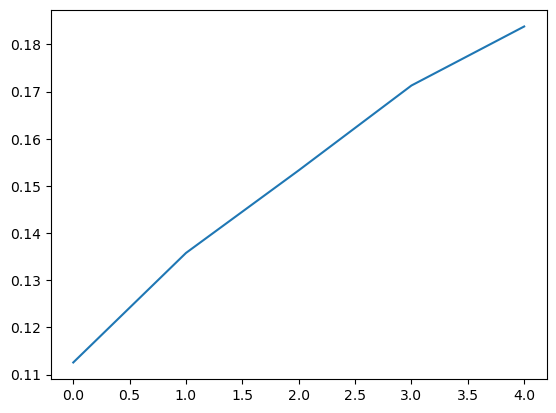

In [61]:
plt.plot(jnp.log(mean_loops[:-1,-5] / mean_loops[:-1,-4]))
plt.show()

In [62]:
sigma, V0, alpha = jnp.polyfit(
    1+jnp.arange(4+1).astype(jnp.float32),
    jnp.log(mean_loops[:-1,-5] / mean_loops[:-1,-4]) * (1+jnp.arange(4+1)),
    deg=2
)

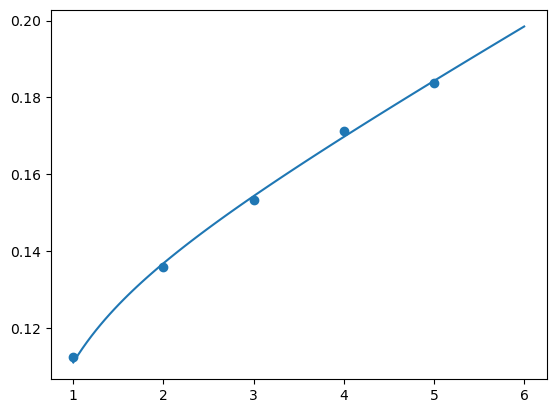

In [64]:
x = 1+jnp.linspace(0, 5, 100)
y = V0 + alpha / x + sigma * x

plt.scatter(1+jnp.arange(4+1), jnp.log(mean_loops[:-1,-5] / mean_loops[:-1,-4]))
plt.plot(x, y)
plt.show()

In [65]:
jnp.sqrt(sigma) / 440 * 1000 * 0.1973164956590371

Array(0.05178249, dtype=float32)